This notebook implements calculates genetic values for individuals based on causal mutations in a GRG. The workflow begins by simulating effect sizes for 1,000 causal mutations using multivariate normal (and exponential) distributions with specified mean and covariance. It assigns these simulated effect sizes to specific mutation sites in the GRG, computes additive genetic values for each sample node by summing contributions from all causal mutations carried by that node, aggregates the two haploid sample nodes into diploid individuals, and finally normalizes the genetic values to have zero mean and unit variance for each trait. The notebook demonstrates handling multiple correlated traits simultaneously and includes validation steps to confirm the normalization achieves the expected statistical properties.

In [ ]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.split import split_genetic_values

from test_phenotype_sim.effect_size_test import test_additive_effect_sizes
from test_phenotype_sim.genetic_value_test import split_sample_df, split_causal_mutation_df, split_normalized_genetic_values



The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation. The bash script below will function as expected given the relative path for the source data file is accurate.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[ 0.67715089  0.39266083]
 [ 2.1764931   1.44004109]
 [-0.18499214  0.19017276]
 ...
 [ 0.87646773  0.94437909]
 [-0.02630375 -0.44511384]
 [ 0.70261781 -0.819115  ]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)

trait_df_normal_multi #this is the pandas data frame showing the results using the normal distribution

,mutation_id,effect_size,causal_mutation_id
0,20,1.017136,0
1,20,-2.174609,1
2,28,-0.755420,0
3,28,1.053215,1
4,62,0.195407,0
...,...,...,...
1995,10879,-0.357138,1
1996,10883,-0.410175,0
1997,10883,-0.750285,1
1998,10889,-0.303153,0


In [6]:
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
sample_nodes_df_multi #the pandas dataframe containing only the sample nodes and their associated effect sizes, 400*n sample nodes expected, where n is the number of unique causal mutation ids

,sample_node_id,genetic_value,causal_mutation_id
0,0,-10.557173,0
1,0,-16.766413,1
2,1,-27.385206,0
3,1,-6.321293,1
4,2,-5.474066,0
...,...,...,...
795,397,-13.917601,1
796,398,-6.870744,0
797,398,-5.014950,1
798,399,-3.730808,0


In [7]:
split_genetic_values(sample_nodes_df_multi, return_print=True)

     sample_node_id  genetic_value  causal_mutation_id
0                 0     -10.557173                   0
2                 1     -27.385206                   0
4                 2      -5.474066                   0
6                 3     -14.434160                   0
8                 4      -7.879660                   0
..              ...            ...                 ...
790             395       3.077320                   0
792             396     -15.119792                   0
794             397     -13.001552                   0
796             398      -6.870744                   0
798             399      -3.730808                   0

[400 rows x 3 columns]
     sample_node_id  genetic_value  causal_mutation_id
1                 0     -16.766413                   1
3                 1      -6.321293                   1
5                 2      -8.913498                   1
7                 3     -13.326531                   1
9                 4     -14.108230       

In [8]:
split_df_list = split_genetic_df = split_genetic_values(sample_nodes_df_multi, return_list=True)
split_df_list[0] #the first dataframe

,sample_node_id,genetic_value,causal_mutation_id
0,0,-10.557173,0
2,1,-27.385206,0
4,2,-5.474066,0
6,3,-14.434160,0
8,4,-7.879660,0
...,...,...,...
790,395,3.077320,0
792,396,-15.119792,0
794,397,-13.001552,0
796,398,-6.870744,0


In [9]:
split_df_list[1] #the second dataframe

,sample_node_id,genetic_value,causal_mutation_id
1,0,-16.766413,1
3,1,-6.321293,1
5,2,-8.913498,1
7,3,-13.326531,1
9,4,-14.108230,1
...,...,...,...
791,395,12.042995,1
793,396,-3.609428,1
795,397,-13.917601,1
797,398,-5.014950,1


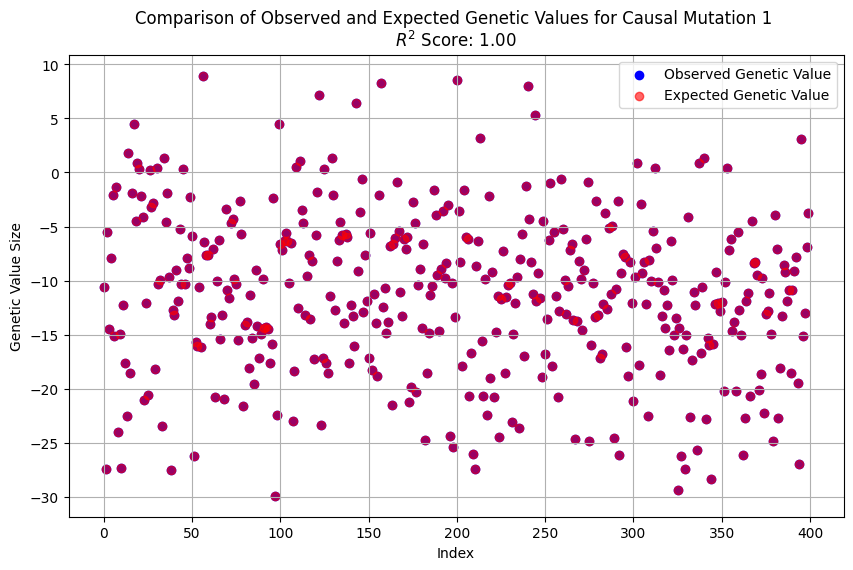

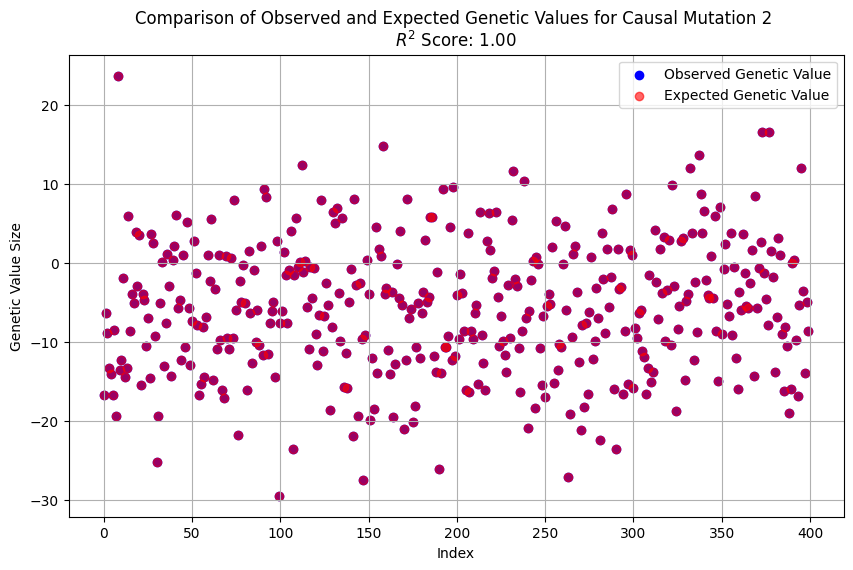

In [10]:
df_dict, num = split_sample_df(sample_nodes_df_multi)
causal_mutation_df_dict = split_causal_mutation_df(trait_df_normal_multi)

ground_truth_genetic_values = {i: None for i in range(num)}

for i in range(num):
  ground_truth_genetic_values[i] = test_additive_effect_sizes(grg_1, causal_mutation_df_dict[i])
  r2 = r2_score(ground_truth_genetic_values[i], df_dict[i]['genetic_value']) #plotting the expected versus actual genetic values to verify the additive function

  plt.figure(figsize=(10, 6))
  plt.scatter(range(len(df_dict[i]['genetic_value'])), df_dict[i]['genetic_value'], color='blue', label='Observed Genetic Value')
  plt.scatter(range(len(ground_truth_genetic_values[i])), ground_truth_genetic_values[i], color='red', alpha=0.6, label='Expected Genetic Value')

  plt.title(f'Comparison of Observed and Expected Genetic Values for Causal Mutation {i+1} \n$R^2$ Score: {r2:.2f}')
  plt.xlabel('Index')
  plt.ylabel('Genetic Value Size')
  plt.legend()

  plt.grid(True)

  plt.show()


The two graphs above demonstrate that the genetic values for each of the causal mutations are calculated as expected by cross-verifying the values with the output generated by recursively verifying the ancestral mutation nodes in the GRG.

In [11]:
individuals = samples_to_individuals(sample_nodes_df_multi)
individuals

,individual_id,genetic_value,causal_mutation_id
0,0,-37.942379,0
1,0,-23.087706,1
2,1,-19.908226,0
3,1,-22.240029,1
4,2,-9.933216,0
...,...,...,...
395,197,6.632294,1
396,198,-28.121344,0
397,198,-17.527029,1
398,199,-10.601552,0


In [12]:
normalized_individual_multi_normal = normalize_genetic_values(individuals)
normalized_individual_multi_normal

,individual_id,genetic_value,causal_mutation_id
0,0,-1.472805,0
1,0,-0.980158,1
2,1,0.247969,0
3,1,-0.908911,1
4,2,1.199759,0
...,...,...,...
395,197,1.517808,1
396,198,-0.535707,0
397,198,-0.512783,1
398,199,1.135988,0


In [13]:
normalized_dict, num = split_normalized_genetic_values(normalized_individual_multi_normal)


for i in range(num):
  print("The new mean of genetic values for causal mutation " + str(i+1) + " is " + str(normalized_dict[i]['genetic_value'].mean()))
  print("The new standard deviation of genetic values for causal mutation " + str(i+1) + " is " + str(normalized_dict[i]['genetic_value'].std()))



The new mean of genetic values for causal mutation 1 is -8.881784197001253e-17
The new standard deviation of genetic values for causal mutation 1 is 0.9999999999999998
The new mean of genetic values for causal mutation 2 is 2.575717417130363e-16
The new standard deviation of genetic values for causal mutation 2 is 1.0


Now, we demonstrate multivariate genetic value simulation for more than two causal mutations

In [14]:
rng = np.random.default_rng()

scales_1 = np.array([1, 2, 5])
model_exp_multi = grg_causal_mutation_model("multivariate exponential", scales=scales_1, random_sign=False)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_exp_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[0.24425221 4.16400542 6.32925004]
 [0.60118746 1.36463913 4.99945755]
 [1.4271733  2.69196499 7.69706901]
 ...
 [0.78956544 1.0314835  2.34669712]
 [0.68202537 5.15650145 5.61822214]
 [0.80530321 2.47688818 2.81343262]]


In [15]:
trait_df_exp_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_exp_multi, random_seed=1)
trait_df_exp_multi


,mutation_id,effect_size,causal_mutation_id
0,20,1.189045,0
1,20,3.533118,1
2,20,4.872985,2
3,28,1.247007,0
4,28,1.786008,1
...,...,...,...
2995,10883,0.135702,1
2996,10883,5.343316,2
2997,10889,0.945416,0
2998,10889,2.663471,1


In [16]:
sample_nodes_df_multi_exp = additive_effect_sizes(grg_1, trait_df_exp_multi)
sample_nodes_df_multi_exp #the pandas dataframe containing only the sample nodes and their associated effect sizes, 400*n sample nodes expected, where n is the number of unique causal mutation ids

,sample_node_id,genetic_value,causal_mutation_id
0,0,116.574729,0
1,0,222.904428,1
2,0,616.287580,2
3,1,129.155527,0
4,1,222.633018,1
...,...,...,...
1195,398,217.911792,1
1196,398,712.865087,2
1197,399,113.969150,0
1198,399,203.876678,1


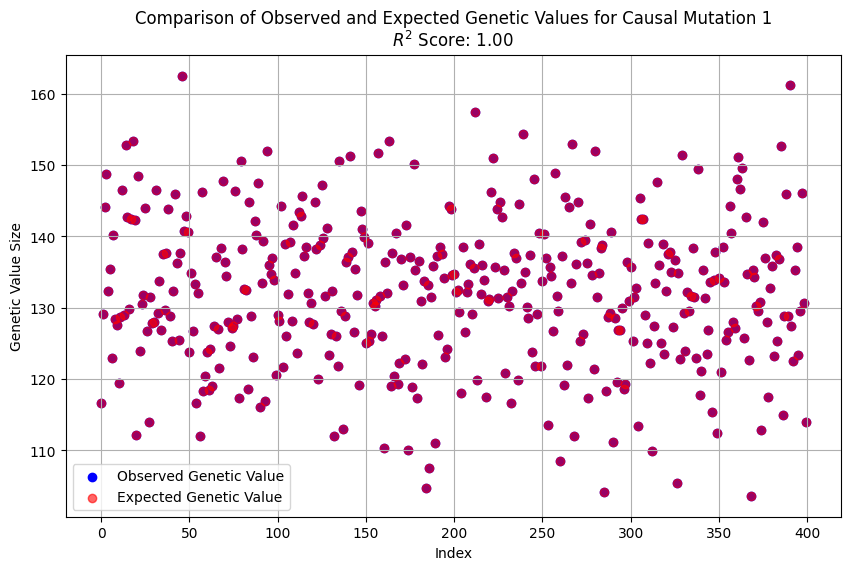

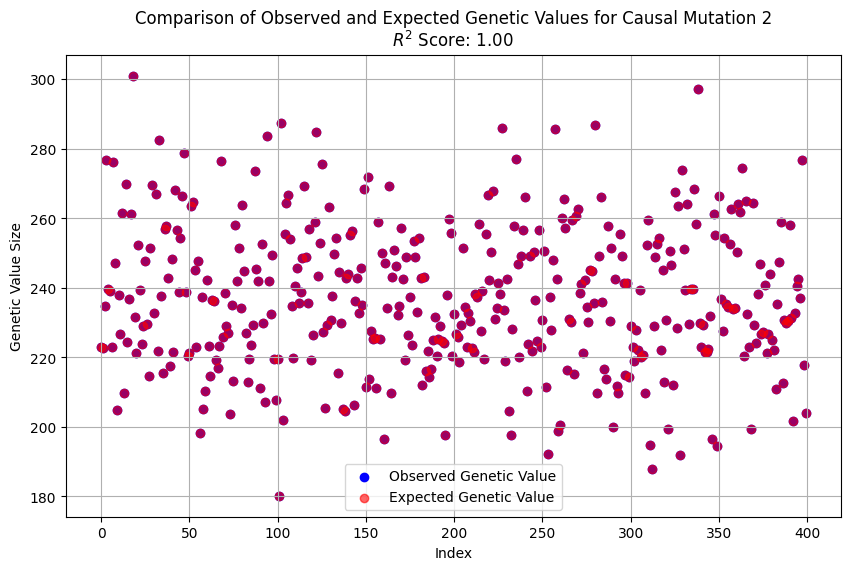

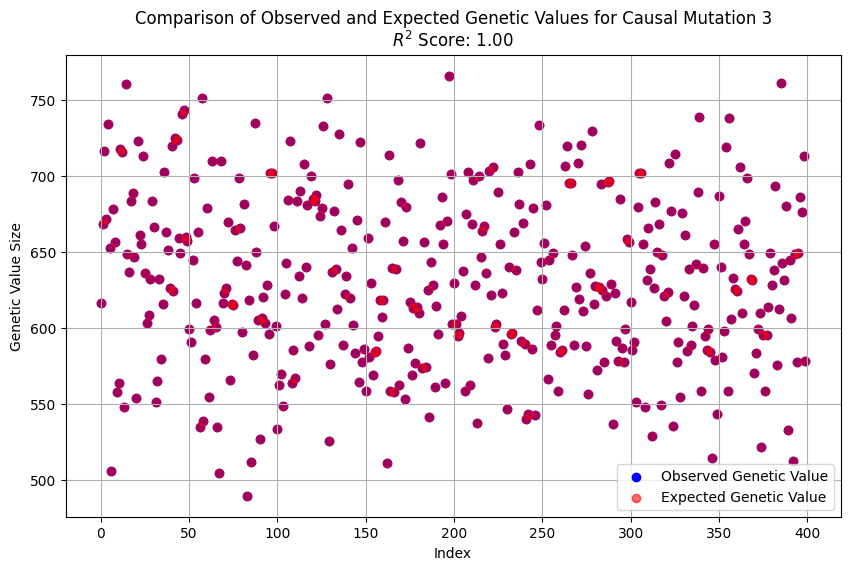

In [17]:
df_dict, num = split_sample_df(sample_nodes_df_multi_exp)
causal_mutation_df_dict = split_causal_mutation_df(trait_df_exp_multi)

ground_truth_genetic_values = {i: None for i in range(num)}

for i in range(num):
  ground_truth_genetic_values[i] = test_additive_effect_sizes(grg_1, causal_mutation_df_dict[i])
  r2 = r2_score(ground_truth_genetic_values[i], df_dict[i]['genetic_value']) #plotting the expected versus actual genetic values to verify the additive function

  plt.figure(figsize=(10, 6))
  plt.scatter(range(len(df_dict[i]['genetic_value'])), df_dict[i]['genetic_value'], color='blue', label='Observed Genetic Value')
  plt.scatter(range(len(ground_truth_genetic_values[i])), ground_truth_genetic_values[i], color='red', alpha=0.6, label='Expected Genetic Value')

  plt.title(f'Comparison of Observed and Expected Genetic Values for Causal Mutation {i+1}\n$R^2$ Score: {r2:.2f}')
  plt.xlabel('Index')
  plt.ylabel('Genetic Value Size')
  plt.legend()

  plt.grid(True)

  plt.show()


The three graphs above demonstrate that the genetic values computed for all three causal mutations are exactly as predicted by the recursive ancestral method

In [18]:
individuals_exp_multi = samples_to_individuals(sample_nodes_df_multi_exp)
individuals_exp_multi

,individual_id,genetic_value,causal_mutation_id
0,0,245.730256,0
1,0,445.537446,1
2,0,1284.586517,2
3,1,292.778964,0
4,1,511.631470,1
...,...,...,...
595,198,513.667099,1
596,198,1362.505355,2
597,199,244.629173,0
598,199,421.788470,1


In [19]:
normalized_individuals_multi_exp = normalize_genetic_values(individuals_exp_multi)
normalized_individuals_multi_exp

,individual_id,genetic_value,causal_mutation_id
0,0,-1.335029,0
1,0,-0.984942,1
2,0,0.311072,2
3,1,2.084290,0
4,1,1.314243,1
...,...,...,...
595,198,1.385055,1
596,198,1.315302,2
597,199,-1.415051,0
598,199,-1.811087,1


In [20]:
normalized_dict, num = split_normalized_genetic_values(normalized_individuals_multi_exp)


for i in range(num):
  print("The new mean of genetic values for causal mutation " + str(i+1) + " is " + str(normalized_dict[i]['genetic_value'].mean()))
  print("The new standard deviation of genetic values for causal mutation " + str(i+1) + " is " + str(normalized_dict[i]['genetic_value'].std()))



The new mean of genetic values for causal mutation 1 is -1.0258460747536447e-15
The new standard deviation of genetic values for causal mutation 1 is 0.9999999999999999
The new mean of genetic values for causal mutation 2 is 2.0516921495072893e-15
The new standard deviation of genetic values for causal mutation 2 is 0.9999999999999998
The new mean of genetic values for causal mutation 3 is 2.0028423364237823e-15
The new standard deviation of genetic values for causal mutation 3 is 0.9999999999999999
